Using device: cuda
Loading CIFAR-10 data...

TRAINING MC DROPOUT MODEL
Epoch [1/50], Step [100/391], Loss: 1.8075, Acc: 32.40%
Epoch [1/50], Step [200/391], Loss: 1.6700, Acc: 37.76%
Epoch [1/50], Step [300/391], Loss: 1.5794, Acc: 41.39%
Epoch [1/50] - Loss: 1.5109, Accuracy: 44.19%

Epoch [2/50], Step [100/391], Loss: 1.2082, Acc: 56.30%
Epoch [2/50], Step [200/391], Loss: 1.1789, Acc: 57.61%
Epoch [2/50], Step [300/391], Loss: 1.1552, Acc: 58.62%
Epoch [2/50] - Loss: 1.1308, Accuracy: 59.56%

Epoch [3/50], Step [100/391], Loss: 1.0055, Acc: 64.20%
Epoch [3/50], Step [200/391], Loss: 0.9866, Acc: 64.99%
Epoch [3/50], Step [300/391], Loss: 0.9761, Acc: 65.60%
Epoch [3/50] - Loss: 0.9623, Accuracy: 66.22%

Epoch [4/50], Step [100/391], Loss: 0.8795, Acc: 69.09%
Epoch [4/50], Step [200/391], Loss: 0.8737, Acc: 69.18%
Epoch [4/50], Step [300/391], Loss: 0.8643, Acc: 69.71%
Epoch [4/50] - Loss: 0.8600, Accuracy: 69.86%

Epoch [5/50], Step [100/391], Loss: 0.7918, Acc: 72.46%
Epoch [5/50],

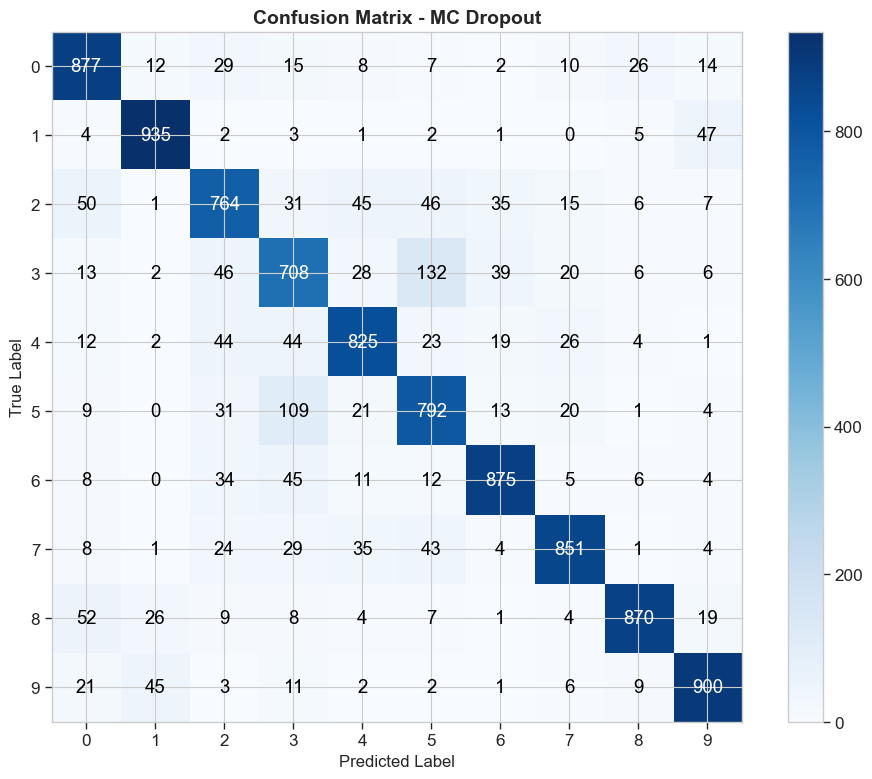

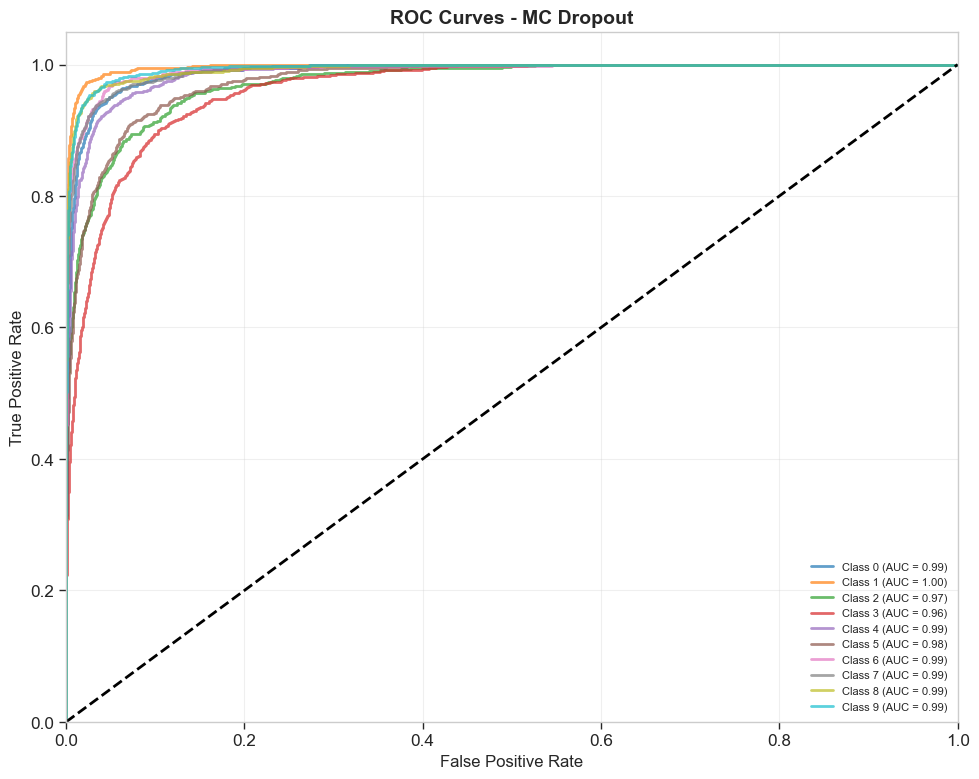

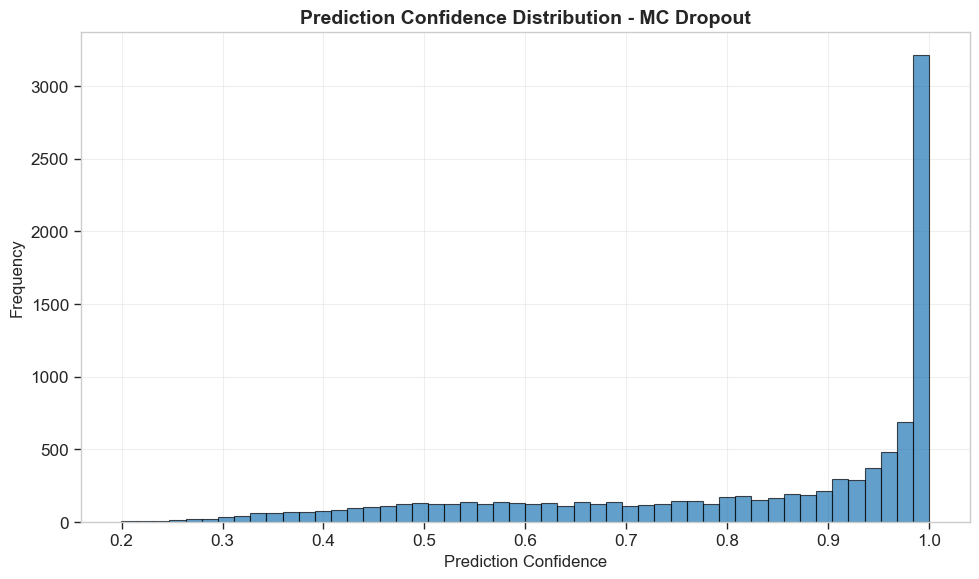

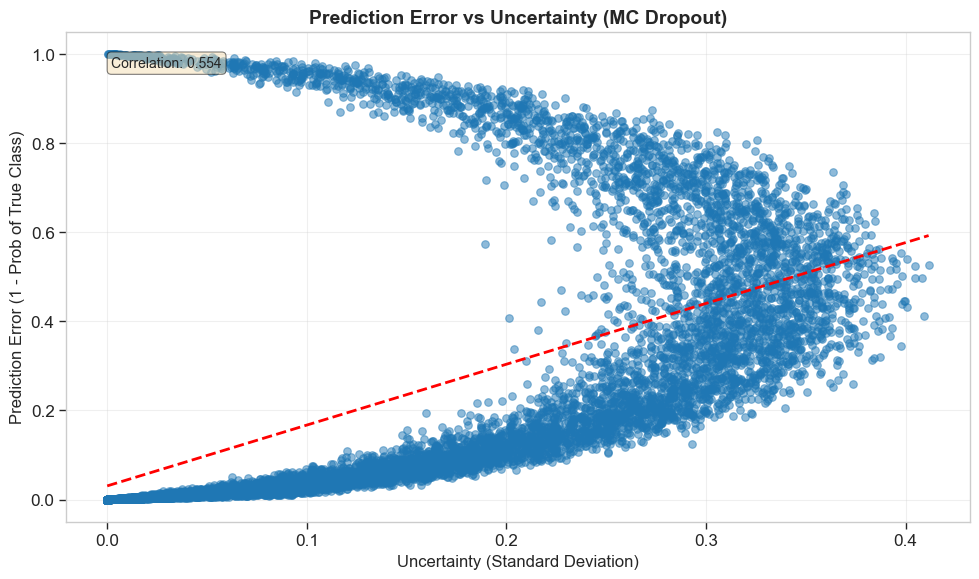

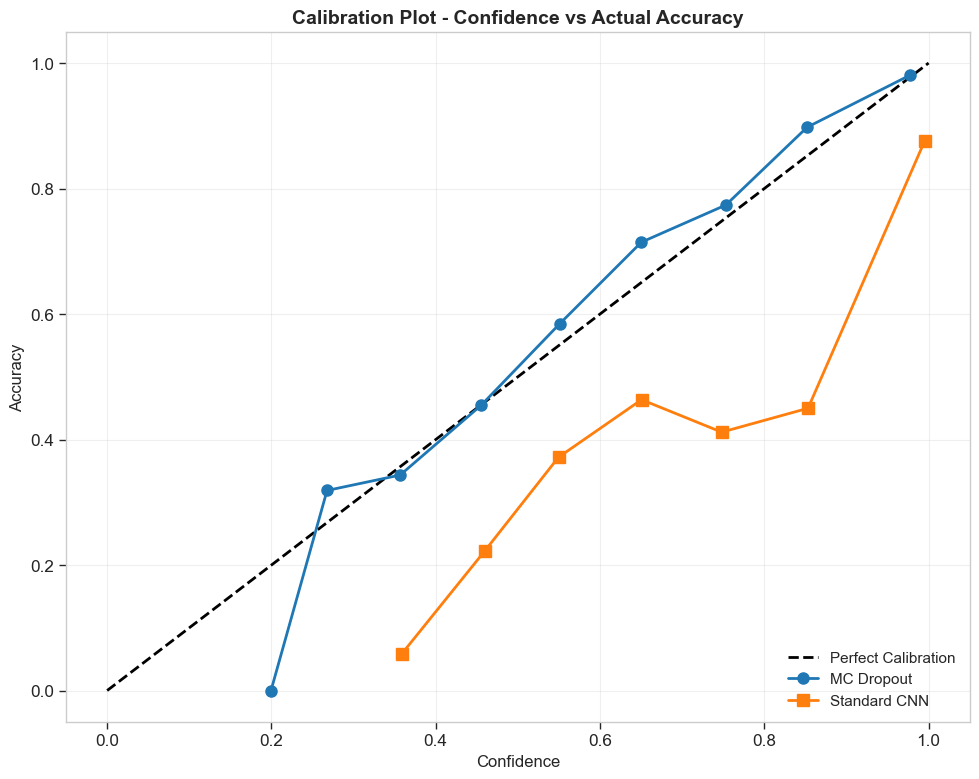

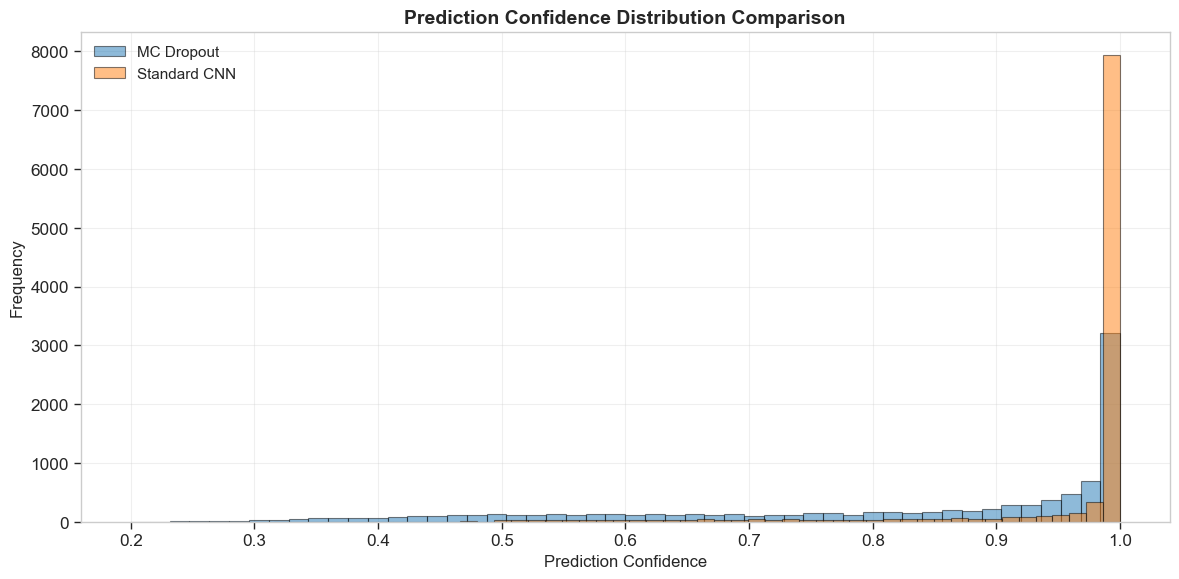


MC DROPOUT METRICS
Accuracy: 83.97%
Mean Uncertainty: 0.1516
Mean Confidence: 0.8236

STANDARD CNN METRICS
Accuracy: 82.12%
Mean Confidence: 0.9611


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import os

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load CIFAR-10 dataset
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_cifar10_data(data_path):
    """Load all CIFAR-10 batches"""
    X_train, y_train = [], []
    
    for i in range(1, 6):
        batch_file = os.path.join(os.path.dirname(data_path), f'data_batch_{i}')
        batch_data = unpickle(batch_file)
        X_train.append(batch_data[b'data'])
        y_train.extend(batch_data[b'labels'])
    
    X_train = np.vstack(X_train)
    y_train = np.array(y_train)
    
    test_file = os.path.join(os.path.dirname(data_path), 'test_batch')
    test_data = unpickle(test_file)
    X_test = test_data[b'data']
    y_test = np.array(test_data[b'labels'])
    
    X_train = X_train.reshape(-1, 3, 32, 32).astype(np.float32) / 255.0
    X_test = X_test.reshape(-1, 3, 32, 32).astype(np.float32) / 255.0
    
    return X_train, y_train, X_test, y_test

class CIFAR10Dataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# MC Dropout Model
class MCDropoutCNN(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super(MCDropoutCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout2d(dropout_rate)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout2d(dropout_rate)
        
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout2d(dropout_rate)
        
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.dropout4 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        x = self.relu(self.bn5(self.conv5(x)))
        x = self.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = self.dropout3(x)
        
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout4(x)
        x = self.fc2(x)
        return x

# Standard Model (no dropout during inference)
class StandardCNN(nn.Module):
    def __init__(self):
        super(StandardCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        
        x = self.relu(self.bn5(self.conv5(x)))
        x = self.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train_model(model, train_loader, criterion, optimizer, epochs=50):
    """Train the model"""
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, (X_batch, y_batch) in enumerate(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
            
            if (i + 1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], '
                      f'Loss: {running_loss/(i+1):.4f}, Acc: {100*correct/total:.2f}%')
        
        print(f'Epoch [{epoch+1}/{epochs}] - Loss: {running_loss/len(train_loader):.4f}, '
              f'Accuracy: {100*correct/total:.2f}%\n')

def mc_dropout_predict(model, dataloader, n_iterations=100):
    """MC Dropout predictions"""
    model.train()  # Keep dropout active
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            batch_predictions = []
            
            for _ in range(n_iterations):
                outputs = model(X_batch)
                probs = torch.softmax(outputs, dim=1)
                batch_predictions.append(probs.cpu().numpy())
            
            all_predictions.append(np.array(batch_predictions))
            all_labels.extend(y_batch.numpy())
    
    mc_predictions = np.concatenate([p.transpose(1, 0, 2) for p in all_predictions], axis=0)
    return mc_predictions, np.array(all_labels)

def standard_predict(model, dataloader):
    """Standard predictions"""
    model.eval()
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            probs = torch.softmax(outputs, dim=1)
            all_probs.append(probs.cpu().numpy())
            all_labels.extend(y_batch.numpy())
    
    return np.vstack(all_probs), np.array(all_labels)

def plot_confusion_matrix(y_true, y_pred, title, filename):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title(f'Confusion Matrix - {title}', fontsize=14, fontweight='bold')
    plt.colorbar()
    
    tick_marks = np.arange(10)
    plt.xticks(tick_marks, range(10))
    plt.yticks(tick_marks, range(10))
    
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()

def plot_roc_curve(y_true, y_probs, title, filename):
    """Plot ROC curve for multi-class"""
    y_true_bin = label_binarize(y_true, classes=range(10))
    
    plt.figure(figsize=(10, 8))
    
    for i in range(10):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, alpha=0.7, label=f'Class {i} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curves - {title}', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=8)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_confidence_histogram(confidences, title, filename):
    """Plot prediction confidence histogram"""
    plt.figure(figsize=(10, 6))
    plt.hist(confidences, bins=50, edgecolor='black', alpha=0.7)
    plt.xlabel('Prediction Confidence', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title(f'Prediction Confidence Distribution - {title}', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_calibration(y_true, y_probs, y_pred, n_bins=10):
    """Plot calibration curve"""
    confidences = np.max(y_probs, axis=1)
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    
    accuracies = []
    confidences_binned = []
    
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (confidences > bin_lower) & (confidences <= bin_upper)
        prop_in_bin = in_bin.mean()
        
        if prop_in_bin > 0:
            accuracy_in_bin = (y_true[in_bin] == y_pred[in_bin]).mean()
            avg_confidence_in_bin = confidences[in_bin].mean()
            accuracies.append(accuracy_in_bin)
            confidences_binned.append(avg_confidence_in_bin)
    
    return confidences_binned, accuracies

def plot_comparison_calibration(mc_calib, std_calib, filename):
    """Plot calibration comparison"""
    plt.figure(figsize=(10, 8))
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Perfect Calibration')
    plt.plot(mc_calib[0], mc_calib[1], 'o-', lw=2, label='MC Dropout', markersize=8)
    plt.plot(std_calib[0], std_calib[1], 's-', lw=2, label='Standard CNN', markersize=8)
    
    plt.xlabel('Confidence', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Calibration Plot - Confidence vs Actual Accuracy', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_comparison_confidence_histogram(mc_conf, std_conf, filename):
    """Plot confidence histogram comparison"""
    plt.figure(figsize=(12, 6))
    
    plt.hist(mc_conf, bins=50, alpha=0.5, label='MC Dropout', edgecolor='black')
    plt.hist(std_conf, bins=50, alpha=0.5, label='Standard CNN', edgecolor='black')
    
    plt.xlabel('Prediction Confidence', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title('Prediction Confidence Distribution Comparison', fontsize=14, fontweight='bold')
    plt.legend(loc='upper left', fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_uncertainty_vs_error(uncertainty, error, filename):
    """Plot uncertainty vs prediction error (already in original code)"""
    plt.figure(figsize=(10, 6))
    plt.scatter(uncertainty, error, alpha=0.5, s=30)
    plt.xlabel('Uncertainty (Standard Deviation)', fontsize=12)
    plt.ylabel('Prediction Error (1 - Prob of True Class)', fontsize=12)
    plt.title('Prediction Error vs Uncertainty (MC Dropout)', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    slope, intercept, r_value, _, _ = stats.linregress(uncertainty, error)
    x_range = np.linspace(min(uncertainty), max(uncertainty), 200)
    y_fit = intercept + slope * x_range
    plt.plot(x_range, y_fit, 'r--', linewidth=2)
    
    correlation = np.corrcoef(uncertainty, error)[0, 1]
    plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
             transform=plt.gca().transAxes, 
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
             verticalalignment='top', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    data_path = r"C:\Users\nithi\Downloads\cifar-10-batches-py\data_batch_1"
    
    print("Loading CIFAR-10 data...")
    X_train, y_train, X_test, y_test = load_cifar10_data(data_path)
    
    train_dataset = CIFAR10Dataset(X_train, y_train)
    test_dataset = CIFAR10Dataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
    
    # Train MC Dropout Model
    print("\n" + "="*50)
    print("TRAINING MC DROPOUT MODEL")
    print("="*50)
    mc_model = MCDropoutCNN(dropout_rate=0.2).to(device)
    train_model(mc_model, train_loader, nn.CrossEntropyLoss(), 
                optim.Adam(mc_model.parameters(), lr=0.001), epochs=50)
    
    # Train Standard Model
    print("\n" + "="*50)
    print("TRAINING STANDARD MODEL")
    print("="*50)
    std_model = StandardCNN().to(device)
    train_model(std_model, train_loader, nn.CrossEntropyLoss(), 
                optim.Adam(std_model.parameters(), lr=0.001), epochs=50)
    
    # MC Dropout Predictions
    print("\nPerforming MC Dropout predictions...")
    mc_predictions, y_test_labels = mc_dropout_predict(mc_model, test_loader, n_iterations=100)
    mc_pred_mean = np.mean(mc_predictions, axis=1)
    mc_pred_std = np.std(mc_predictions, axis=1)
    mc_pred_classes = np.argmax(mc_pred_mean, axis=1)
    mc_confidences = np.max(mc_pred_mean, axis=1)
    
    # Standard Predictions
    print("Performing Standard predictions...")
    std_probs, _ = standard_predict(std_model, test_loader)
    std_pred_classes = np.argmax(std_probs, axis=1)
    std_confidences = np.max(std_probs, axis=1)
    
    # Calculate uncertainty and error for MC Dropout
    true_class_probs = mc_pred_mean[np.arange(len(y_test_labels)), y_test_labels]
    true_class_std = mc_pred_std[np.arange(len(y_test_labels)), y_test_labels]
    prediction_error = 1.0 - true_class_probs
    
    # Generate all plots
    print("\nGenerating visualizations...")
    
    # MC Dropout plots
    plot_confusion_matrix(y_test_labels, mc_pred_classes, 'MC Dropout', 
                         'mc_confusion_matrix.png')
    plot_roc_curve(y_test_labels, mc_pred_mean, 'MC Dropout', 
                  'mc_roc_curve.png')
    plot_confidence_histogram(mc_confidences, 'MC Dropout', 
                            'mc_confidence_histogram.png')
    plot_uncertainty_vs_error(true_class_std, prediction_error, 
                            'mc_uncertainty_vs_error.png')
    
    # Comparison plots
    mc_calib = plot_calibration(y_test_labels, mc_pred_mean, mc_pred_classes)
    std_calib = plot_calibration(y_test_labels, std_probs, std_pred_classes)
    plot_comparison_calibration(mc_calib, std_calib, 'calibration_comparison.png')
    plot_comparison_confidence_histogram(mc_confidences, std_confidences, 
                                        'confidence_histogram_comparison.png')
    
    # Print metrics
    print("\n" + "="*50)
    print("MC DROPOUT METRICS")
    print("="*50)
    print(f"Accuracy: {100*accuracy_score(y_test_labels, mc_pred_classes):.2f}%")
    print(f"Mean Uncertainty: {np.mean(true_class_std):.4f}")
    print(f"Mean Confidence: {np.mean(mc_confidences):.4f}")
    
    print("\n" + "="*50)
    print("STANDARD CNN METRICS")
    print("="*50)
    print(f"Accuracy: {100*accuracy_score(y_test_labels, std_pred_classes):.2f}%")
    print(f"Mean Confidence: {np.mean(std_confidences):.4f}")
    

Using device: cuda
1. Loading Data...

2. Initializing Models...

3. Training Models...

Training PBP (Standard)...
[STD] Epoch [1/50] - Loss: 1.2419, Acc: 55.57%
[STD] Epoch [2/50] - Loss: 0.8257, Acc: 70.74%
[STD] Epoch [3/50] - Loss: 0.6962, Acc: 75.46%
[STD] Epoch [4/50] - Loss: 0.6074, Acc: 78.39%
[STD] Epoch [5/50] - Loss: 0.5373, Acc: 81.12%
[STD] Epoch [6/50] - Loss: 0.4757, Acc: 83.32%
[STD] Epoch [7/50] - Loss: 0.4234, Acc: 85.06%
[STD] Epoch [8/50] - Loss: 0.3763, Acc: 86.86%
[STD] Epoch [9/50] - Loss: 0.3345, Acc: 88.10%
[STD] Epoch [10/50] - Loss: 0.2954, Acc: 89.53%
[STD] Epoch [11/50] - Loss: 0.2528, Acc: 91.04%
[STD] Epoch [12/50] - Loss: 0.2179, Acc: 92.42%
[STD] Epoch [13/50] - Loss: 0.1938, Acc: 93.10%
[STD] Epoch [14/50] - Loss: 0.1596, Acc: 94.52%
[STD] Epoch [15/50] - Loss: 0.1380, Acc: 95.24%
[STD] Epoch [16/50] - Loss: 0.1236, Acc: 95.64%
[STD] Epoch [17/50] - Loss: 0.1131, Acc: 95.97%
[STD] Epoch [18/50] - Loss: 0.0956, Acc: 96.68%
[STD] Epoch [19/50] - Loss: 0

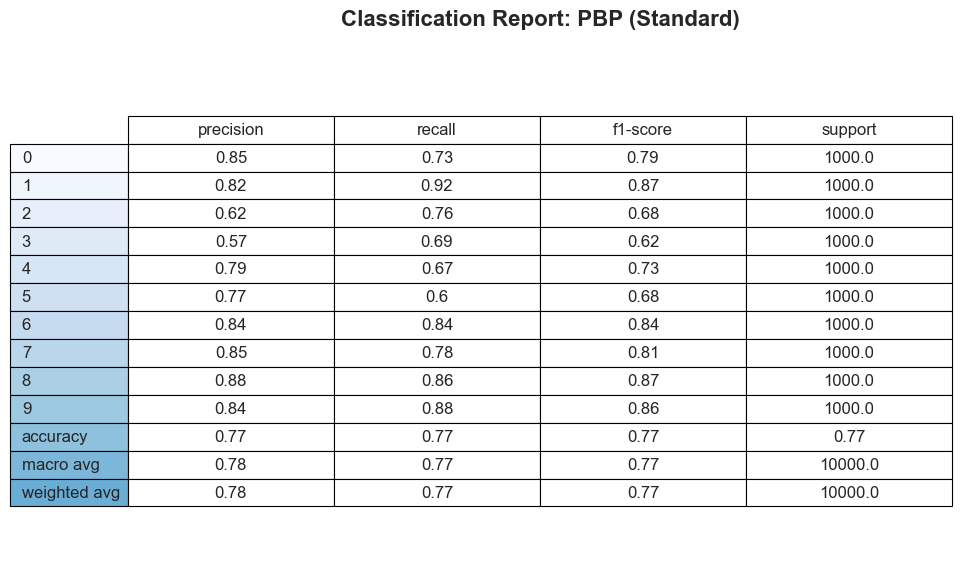

Processing MC Dropout...


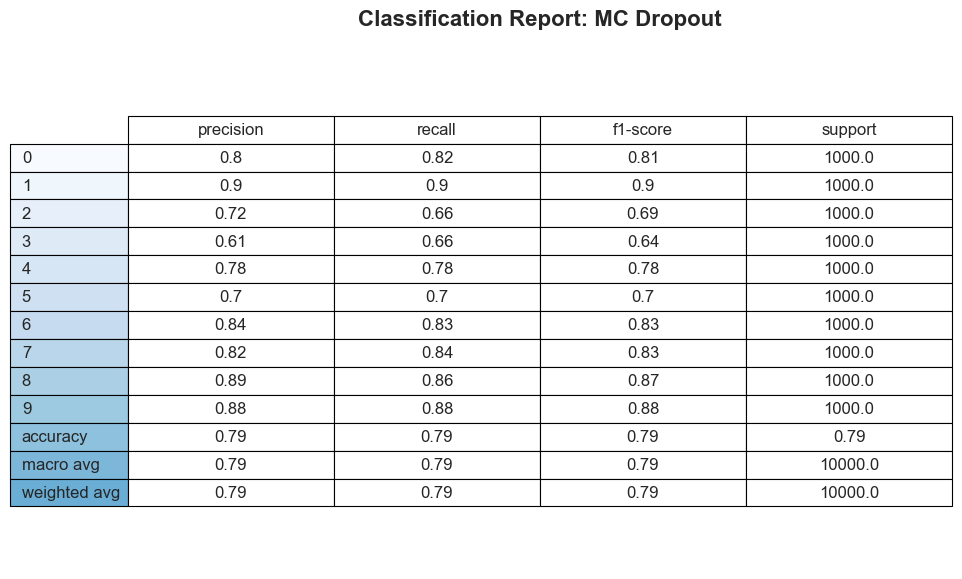

Processing VI (Bayesian)...


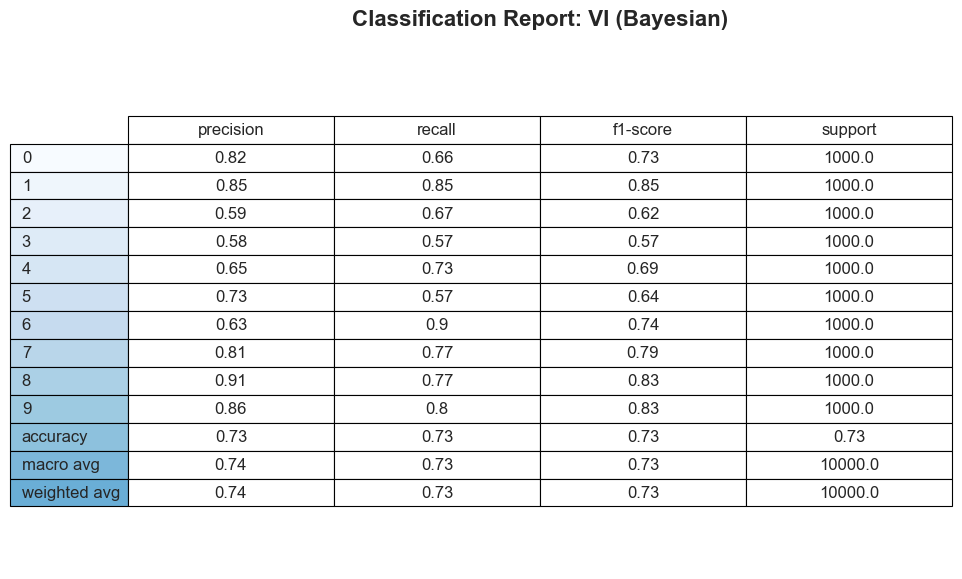


5. Generating Comparison Visualizations...


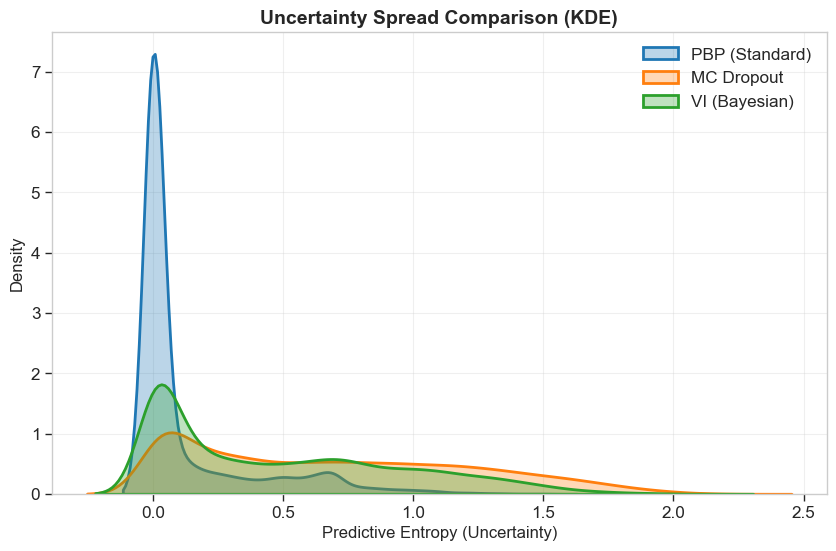

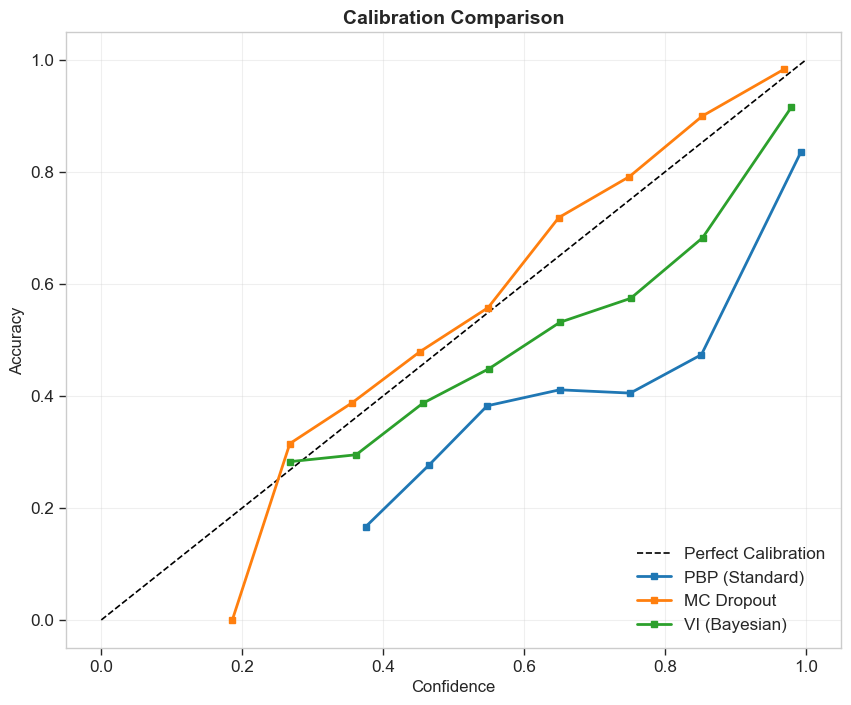

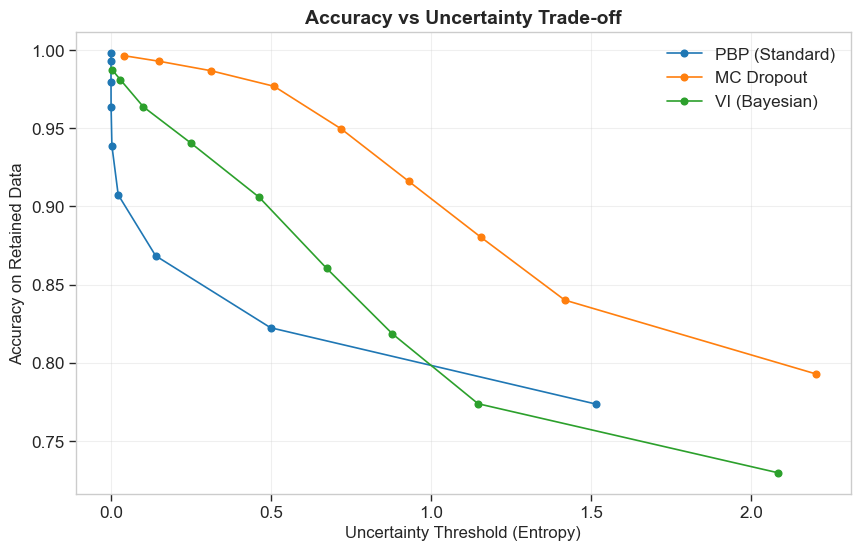

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.preprocessing import label_binarize
import os
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Set formatting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("paper", font_scale=1.4)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ==========================================
# DATA LOADING UTILS
# ==========================================

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_cifar10_data(data_path):
    """Load all CIFAR-10 batches"""
    X_train, y_train = [], []
    
    # Load training batches
    parent_dir = os.path.dirname(data_path)
    for i in range(1, 6):
        batch_file = os.path.join(parent_dir, f'data_batch_{i}')
        if not os.path.exists(batch_file):
             # Fallback if user points directly to a file
             if i == 1 and os.path.isfile(data_path):
                 batch_file = data_path
             else:
                 print(f"Warning: {batch_file} not found. Skipping.")
                 continue
                 
        batch_data = unpickle(batch_file)
        X_train.append(batch_data[b'data'])
        y_train.extend(batch_data[b'labels'])
    
    X_train = np.vstack(X_train)
    y_train = np.array(y_train)
    
    test_file = os.path.join(parent_dir, 'test_batch')
    if not os.path.exists(test_file):
        print("Warning: test_batch not found. Using a split of train data for testing.")
        split = int(0.8 * len(X_train))
        X_test, y_test = X_train[split:], y_train[split:]
        X_train, y_train = X_train[:split], y_train[:split]
    else:
        test_data = unpickle(test_file)
        X_test = test_data[b'data']
        y_test = np.array(test_data[b'labels'])
    
    X_train = X_train.reshape(-1, 3, 32, 32).astype(np.float32) / 255.0
    X_test = X_test.reshape(-1, 3, 32, 32).astype(np.float32) / 255.0
    
    return X_train, y_train, X_test, y_test

class CIFAR10Dataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# ==========================================
# MODELS
# ==========================================

# 1. Standard Model (PBP - Point Based Prediction)
class StandardCNN(nn.Module):
    def __init__(self):
        super(StandardCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 2. MC Dropout Model
class MCDropoutCNN(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super(MCDropoutCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout2d(dropout_rate)
        
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout2d(dropout_rate)
        
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.dropout3 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
        return x

# 3. Variational Inference (VI) Model Components
class BayesianLinear(nn.Module):
    """Bayesian Linear Layer with Reparameterization Trick"""
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        # Weight parameters
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-0.2, 0.2))
        self.weight_rho = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-5, -4))
        
        # Bias parameters
        self.bias_mu = nn.Parameter(torch.Tensor(out_features).uniform_(-0.2, 0.2))
        self.bias_rho = nn.Parameter(torch.Tensor(out_features).uniform_(-5, -4))
        
        self.kl_div = 0

    def forward(self, x):
        # Calculate standard deviation
        weight_sigma = torch.log1p(torch.exp(self.weight_rho))
        bias_sigma = torch.log1p(torch.exp(self.bias_rho))
        
        # Sample epsilon
        if self.training:
            w_epsilon = torch.randn_like(weight_sigma)
            b_epsilon = torch.randn_like(bias_sigma)
        else:
            w_epsilon = torch.zeros_like(weight_sigma)
            b_epsilon = torch.zeros_like(bias_sigma)
            
        # Reparameterization trick
        weight = self.weight_mu + weight_sigma * w_epsilon
        bias = self.bias_mu + bias_sigma * b_epsilon
        
        # Calculate KL Divergence for this layer
        self.kl_div = (self.kl_loss(self.weight_mu, weight_sigma) + 
                       self.kl_loss(self.bias_mu, bias_sigma))
        
        return F.linear(x, weight, bias)
        
    def kl_loss(self, mu, sigma):
        # Simple KL between Gaussian and Standard Normal prior
        return 0.5 * torch.sum(mu**2 + sigma**2 - torch.log(sigma**2) - 1)

class BayesianCNN(nn.Module):
    def __init__(self):
        super(BayesianCNN, self).__init__()
        # Standard feature extractor
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        # Bayesian Dense Layers
        self.fc1 = BayesianLinear(64 * 8 * 8, 128)
        self.fc2 = BayesianLinear(128, 10)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def get_kl(self):
        return self.fc1.kl_div + self.fc2.kl_div

# ==========================================
# TRAINING FUNCTIONS
# ==========================================

def train_model(model, train_loader, optimizer, epochs=20, model_type='std'):
    model.train()
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, (X_batch, y_batch) in enumerate(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            
            if model_type == 'vi':
                # ELBO Loss = NLL + KL
                nll_loss = criterion(outputs, y_batch)
                kl_weight = 1.0 / len(train_loader.dataset) # batch weight
                kl_loss = model.get_kl() * kl_weight
                loss = nll_loss + kl_loss
            else:
                loss = criterion(outputs, y_batch)
                
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
            
        print(f'[{model_type.upper()}] Epoch [{epoch+1}/{epochs}] - Loss: {running_loss/len(train_loader):.4f}, Acc: {100*correct/total:.2f}%')

# ==========================================
# PREDICTION FUNCTIONS
# ==========================================

def get_predictions(model, loader, model_type='std', n_samples=20):
    model.eval()
    all_preds = []
    all_targets = []
    
    # Enable dropout for MC during inference
    if model_type == 'mc':
        model.train() 
    
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            batch_probs = []
            
            if model_type == 'std':
                out = model(X_batch)
                probs = torch.softmax(out, dim=1).cpu().numpy()
                batch_probs.append(probs) # Shape: (1, Batch, Classes)
            else:
                # For MC and VI, sample multiple times
                for _ in range(n_samples):
                    out = model(X_batch)
                    probs = torch.softmax(out, dim=1).cpu().numpy()
                    batch_probs.append(probs)
            
            # Stack samples: (Samples, Batch, Classes)
            all_preds.append(np.stack(batch_probs))
            all_targets.extend(y_batch.numpy())
            
    # Concatenate batches: (Samples, Total_Data, Classes)
    ensemble_preds = np.concatenate(all_preds, axis=1)
    return ensemble_preds, np.array(all_targets)

# ==========================================
# VISUALIZATION FUNCTIONS
# ==========================================

def calculate_uncertainty_metrics(probs_array):
    """
    probs_array shape: (n_samples, n_data, n_classes)
    """
    # Mean probability across samples
    mean_probs = np.mean(probs_array, axis=0) # (n_data, n_classes)
    
    # Predictive Entropy
    entropy = -np.sum(mean_probs * np.log(mean_probs + 1e-10), axis=1)
    
    # Confidence (Max prob)
    confidence = np.max(mean_probs, axis=1)
    
    # Predictions
    predictions = np.argmax(mean_probs, axis=1)
    
    return mean_probs, predictions, entropy, confidence

def draw_classification_report(y_true, y_pred, title, filename):
    """
    Generates a classification report and saves it as a beautiful table image
    matching the requested style.
    """
    report = classification_report(y_true, y_pred, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    
    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axis('off')
    ax.axis('tight')
    
    # Color map for the table
    colors = plt.cm.Blues(np.linspace(0, 0.5, len(df_report)))
    
    # Create table
    table = ax.table(cellText=df_report.round(2).values,
                     rowLabels=df_report.index,
                     colLabels=df_report.columns,
                     rowColours=colors,
                     loc='center',
                     cellLoc='center')
    
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.5)
    
    plt.title(f"Classification Report: {title}", fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

def plot_kde_uncertainty(results, filename):
    """KDE Plot for Uncertainty Spread Comparison"""
    plt.figure(figsize=(10, 6))
    
    for name, data in results.items():
        sns.kdeplot(data['entropy'], fill=True, label=f"{name}", alpha=0.3, linewidth=2)
        
    plt.xlabel('Predictive Entropy (Uncertainty)', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.title('Uncertainty Spread Comparison (KDE)', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_calibration_curves(results, y_true, filename):
    """Comparison of Calibration Curves"""
    plt.figure(figsize=(10, 8))
    plt.plot([0, 1], [0, 1], "k--", label="Perfect Calibration")
    
    for name, data in results.items():
        # Get mean confidence for plotting
        probs = data['probs'] # (N, 10)
        preds = data['preds']
        confidences = np.max(probs, axis=1)
        
        # Binning
        bins = np.linspace(0, 1, 11)
        bin_accs = []
        bin_confs = []
        
        for i in range(len(bins)-1):
            mask = (confidences > bins[i]) & (confidences <= bins[i+1])
            if np.sum(mask) > 0:
                bin_accs.append(accuracy_score(y_true[mask], preds[mask]))
                bin_confs.append(np.mean(confidences[mask]))
        
        plt.plot(bin_confs, bin_accs, "s-", linewidth=2, label=name)

    plt.xlabel("Confidence", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.title("Calibration Comparison", fontsize=14, fontweight='bold')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_accuracy_vs_uncertainty(results, y_true, filename):
    """Accuracy vs Uncertainty Trade-off Plot"""
    plt.figure(figsize=(10, 6))
    
    for name, data in results.items():
        entropy = data['entropy']
        preds = data['preds']
        
        # Determine thresholds based on percentiles of entropy
        thresholds = np.percentile(entropy, np.linspace(0, 100, 10))
        accuracies = []
        kept_ratios = []
        
        for t in thresholds:
            # Keep predictions where uncertainty < t
            mask = entropy <= t
            if np.sum(mask) > 10: # Avoid empty stats
                acc = accuracy_score(y_true[mask], preds[mask])
                accuracies.append(acc)
                kept_ratios.append(t)
        
        plt.plot(kept_ratios, accuracies, "o-", label=name)
        
    plt.xlabel('Uncertainty Threshold (Entropy)', fontsize=12)
    plt.ylabel('Accuracy on Retained Data', fontsize=12)
    plt.title('Accuracy vs Uncertainty Trade-off', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# ==========================================
# MAIN EXECUTION
# ==========================================
if __name__ == "__main__":
    # CONFIGURATION
    # Update this path to your data location
    DATA_PATH = r"C:\Users\nithi\Downloads\cifar-10-batches-py\data_batch_1"
    EPOCHS = 50 # Reduced for demonstration speed, increase to 50 for better results
    BATCH_SIZE = 128
    
    print("1. Loading Data...")
    X_train, y_train, X_test, y_test = load_cifar10_data(DATA_PATH)
    
    train_loader = DataLoader(CIFAR10Dataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(CIFAR10Dataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False)
    
    print("\n2. Initializing Models...")
    models = {
        'PBP (Standard)': StandardCNN().to(device),
        'MC Dropout': MCDropoutCNN(dropout_rate=0.2).to(device),
        'VI (Bayesian)': BayesianCNN().to(device)
    }
    
    # Optimizers
    optimizers = {
        'PBP (Standard)': optim.Adam(models['PBP (Standard)'].parameters(), lr=0.001),
        'MC Dropout': optim.Adam(models['MC Dropout'].parameters(), lr=0.001),
        'VI (Bayesian)': optim.Adam(models['VI (Bayesian)'].parameters(), lr=0.001)
    }
    
    print("\n3. Training Models...")
    for name, model in models.items():
        print(f"\nTraining {name}...")
        m_type = 'vi' if 'VI' in name else 'std'
        train_model(model, train_loader, optimizers[name], epochs=EPOCHS, model_type=m_type)
        
    print("\n4. Inference and Uncertainty Estimation...")
    results_data = {}
    
    for name, model in models.items():
        print(f"Processing {name}...")
        m_type = 'mc' if 'MC' in name else ('vi' if 'VI' in name else 'std')
        
        # Get ensemble predictions (Shape: Samples x N x Classes)
        raw_preds, _ = get_predictions(model, test_loader, model_type=m_type, n_samples=20)
        
        # Calculate stats
        mean_probs, preds, entropy, conf = calculate_uncertainty_metrics(raw_preds)
        
        results_data[name] = {
            'probs': mean_probs,
            'preds': preds,
            'entropy': entropy,
            'confidence': conf
        }
        
        # Generate Table for this model
        draw_classification_report(y_test, preds, name, f'table_{name.split()[0]}.png')

    print("\n5. Generating Comparison Visualizations...")
    
    # A. Uncertainty Spread (KDE)
    plot_kde_uncertainty(results_data, 'comparison_uncertainty_kde.png')
    
    # B. Calibration Comparison
    plot_calibration_curves(results_data, y_test, 'comparison_calibration.png')
    
    # C. Accuracy vs Uncertainty Trade-off
    plot_accuracy_vs_uncertainty(results_data, y_test, 'comparison_acc_vs_unc.png')
    

In [11]:
import numpy as np

def compute_rmse_loglik(raw_preds, y_true):
    """
    raw_preds: shape (n_samples, N, C)
    y_true: shape (N,)
    """
    # Mean prediction
    mean_probs = np.mean(raw_preds, axis=0)  # (N, C)
    preds = np.argmax(mean_probs, axis=1)

    # -------- RMSE --------
    rmse = np.sqrt(np.mean((preds - y_true)**2))

    # -------- Log-Likelihood --------
    # Extract probability of the true class
    true_probs = mean_probs[np.arange(len(y_true)), y_true]
    log_likelihood = np.mean(np.log(true_probs + 1e-10))

    return rmse, log_likelihood


print("\n================= FINAL METRICS (RMSE & LL) =================\n")

for name, model in models.items():
    print(f"{name}")

    m_type = 'mc' if 'MC' in name else ('vi' if 'VI' in name else 'std')

    # Get 20 sample predictions
    raw_preds, _ = get_predictions(model, test_loader, model_type=m_type, n_samples=20)

    # Compute RMSE & LL for each Monte Carlo sample (to get std deviation)
    rmses = []
    lls = []

    for s in range(raw_preds.shape[0]):
        rmse_s, ll_s = compute_rmse_loglik(raw_preds[s:s+1], y_test)
        rmses.append(rmse_s)
        lls.append(ll_s)

    rmses = np.array(rmses)
    lls = np.array(lls)

    print(f"  Avg Test RMSE: {rmses.mean():.4f} ± {rmses.std():.4f}")
    print(f"  Avg Test LL  : {lls.mean():.4f} ± {lls.std():.4f}\n")



================= FINAL METRICS (RMSE & LL) =================

PBP (Standard)
  Avg Test RMSE: 1.9293 ± 0.0000
  Avg Test LL  : -1.6371 ± 0.0000

MC Dropout
  Avg Test RMSE: 2.1459 ± 0.0238
  Avg Test LL  : -0.9281 ± 0.0093

VI (Bayesian)
  Avg Test RMSE: 2.0953 ± 0.0000
  Avg Test LL  : -0.8932 ± 0.0000

